In [1]:
from IPython.display import clear_output
# import quantities as pq  # doesn't work write on function psi
# import unyt as pq  # doesn't support Siemens natively, it seems(ens)
# import numpy as np
# import matplotlib.pyplot as plt
import brian2 as b2
from brian2 import np
from brian2 import plt
# import networkx as nx
from scipy import special, integrate


from time import sleep


pq = b2
# np.random.seed(111)

In [2]:
defaultdt = 0.05 * pq.ms

N = 1000
N_E = int(N * 0.8)
N_I = N - N_E
f = 0.1
p = 5
N_sub = int(N_E * f)
N_non = N_E - p * N_sub
w_plus = 2.1
w_minus = 1. - f* (w_plus - 1.) / (1. - f)

V_L = -70. * pq.mV
V_thr = -50. * pq.mV
V_reset = -55. * pq.mV
V_E = 0. * pq.mV  # shouldn't be used
V_I = -70 * pq.mV  # shouldn't be used
V_drive = -47.5 * pq.mV
V_avg_initial = -52.5 * pq.mV  # is this needed?

g_AMPA_ext_E = 2.08 * pq.nS * 0.5
g_AMPA_rec_E = 0.104 * pq.nS * 800. / N_E
g_AMPA_ext_I = 1.62 * pq.nS * 0.5
g_AMPA_rec_I = 0.081 * pq.nS * 800. / N_E
tau_AMPA = 2. * pq.ms

g_NMDA_E = 0.327 * pq.nS * 800. / N_E
g_NMDA_I = 0.258 * pq.nS * 800. / N_E
tau_NMDA_rise = 2. * pq.ms
tau_NMDA_decay = 100. * pq.ms
alpha = 0.5 / pq.ms
tau_NMDA = tau_NMDA_rise * alpha * tau_NMDA_decay

gamma_JahrStevens = 1. / 3.57
beta_JahrStevens = 0.062 / pq.mV

g_GABA_E = 1.25 * pq.nS * 200. / N_I
g_GABA_I = 0.973 * pq.nS * 200. / N_I
tau_GABA = 10. * pq.ms

tau_rp_E = 2. * pq.ms
tau_rp_I = 1. * pq.ms
C_m_E = 0.5 * pq.nF
C_m_I = 0.2 * pq.nF
g_m_E = 25. * pq.nS
g_m_I = 20. * pq.nS
tau_m_E = C_m_E / g_m_E
tau_m_I = C_m_I / g_m_I

rate_ext = 3. * pq.Hz
C_ext = 800

# initial values
rate_interneuron = 5. * pq.Hz
rate_pyramidal = 3. * pq.Hz

In [3]:
# Functions to compute steady-state NMDA channels
def _get_Tn_summand(n, m, nu):
    assert n >= 1 and m >= 0
    binom_coeff = (-1)**m * special.binom(n, m)
    numerator = tau_NMDA_rise * (1 + nu * tau_NMDA)
    denominator = tau_NMDA_rise * (1 + nu * tau_NMDA) + m * tau_NMDA_decay
    return binom_coeff * numerator / denominator

def _get_Tn(n, nu):
    assert n >= 1
    Tn = 0
    for m in np.arange(0, n+1):
        Tn += _get_Tn_summand(n, m, nu)
    return Tn

def psi(nu, n_truncate=5):
    """
    Computes fraction of open NMDA channels given presynaptic firing rate nu 
    up until truncation round-off n_truncate.
    """
    coeff = nu * tau_NMDA / (1 + nu * tau_NMDA)
    summation = 0
    for n in np.arange(1, n_truncate+1):
        summand_coeff = ((-alpha * tau_NMDA_rise)**n) / special.factorial(n+1)
        summation += summand_coeff * _get_Tn(n, nu)
    return coeff * (1 + summation / (1 + nu * tau_NMDA))

In [4]:
def psi_approx(nu):
    """Following Wong&Wang 2006, we can approximate psi thusly"""
    gamma = 0.8  # 0.641 in Wong&Wang
    product = gamma * nu * tau_NMDA
    return product/(1 + product)

def psi_regular(nu):
    """Gives the steady-state value under regular firing"""
    product = nu * tau_NMDA
    return product/(1 + product)

In [5]:
# we can truncate early
Hz = np.linspace(0, 80, 20) * pq.Hz
truncations = [1, 2, 3, 5, 10, 20]

most_accurate_truncation = 100
most_accurate = []
for hz in Hz:
    most_accurate.append(psi(hz, n_truncate=most_accurate_truncation))
most_accurate = np.array(most_accurate)

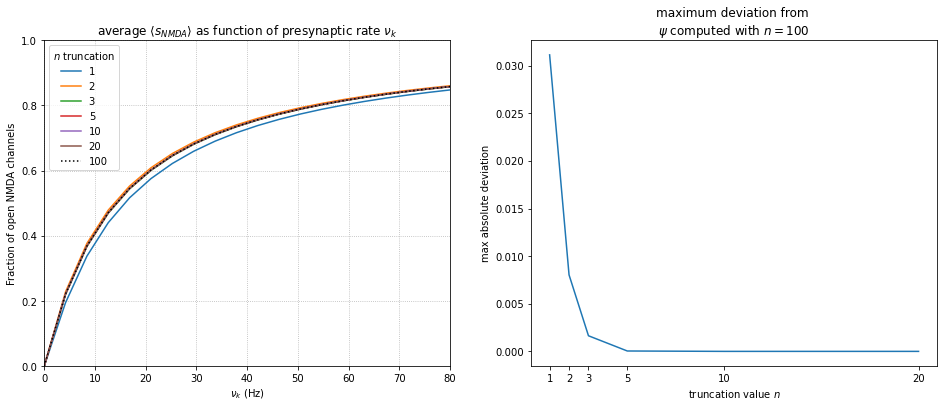

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

max_abs_deviations = []
for n_truncate in truncations:
    s_NMDA_vals = []
    for hz in Hz:
        s_NMDA_vals.append(psi(hz, n_truncate=n_truncate))
    s_NMDA_vals = np.array(s_NMDA_vals)
    max_abs_deviations.append(np.max(
        np.abs(s_NMDA_vals - most_accurate)
    ))
    axes[0].plot(Hz / pq.Hz, s_NMDA_vals, label=n_truncate)
    
axes[0].plot(Hz / pq.Hz, most_accurate, 'k:', label=most_accurate_truncation)
axes[0].grid(ls=':')
axes[0].legend(title='$n$ truncation')
axes[0].set_ylim([0.0, 1.0])
axes[0].set_xlim([0.0, 80.0])
axes[0].set_title(r'average $\langle s_{NMDA} \rangle$ as function of presynaptic rate $\nu_k$')
axes[0].set_xlabel(r'$\nu_k$ (Hz)')
axes[0].set_ylabel('Fraction of open NMDA channels')
axes[1].plot(truncations, max_abs_deviations)
axes[1].set_xticks(truncations)
axes[1].set_xlabel('truncation value $n$')
axes[1].set_ylabel('max absolute deviation')
axes[1].set_title(f'maximum deviation from \n$\psi$ computed with $n={most_accurate_truncation}$')
# fig.savefig('psi_truncation.png')
plt.show()

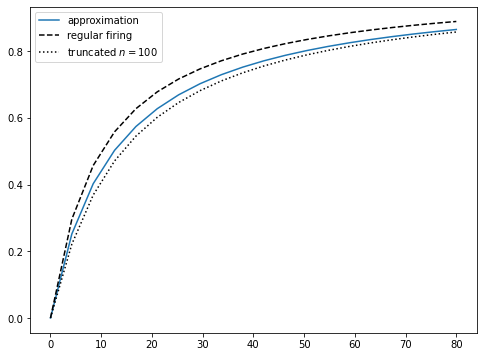

In [7]:
plt.figure(figsize=(8, 6))
plt.plot(Hz/ pq.Hz, psi_approx(Hz), label='approximation')
plt.plot(Hz/ pq.Hz, psi_regular(Hz), 'k--', label='regular firing')
plt.plot(Hz / pq.Hz, most_accurate, 'k:', label=fr'truncated $n={most_accurate_truncation}$')
plt.legend()
plt.show()

In [8]:
# Jahr-Stevens approximations
def J(V):
    return 1 + gamma_JahrStevens * np.exp(-beta_JahrStevens * V)

def J_2(V):
    J_V = J(V)
    numerator = J_V + beta_JahrStevens * (V - V_E)*(J_V - 1)
    denominator = J_V**2
    return numerator / denominator

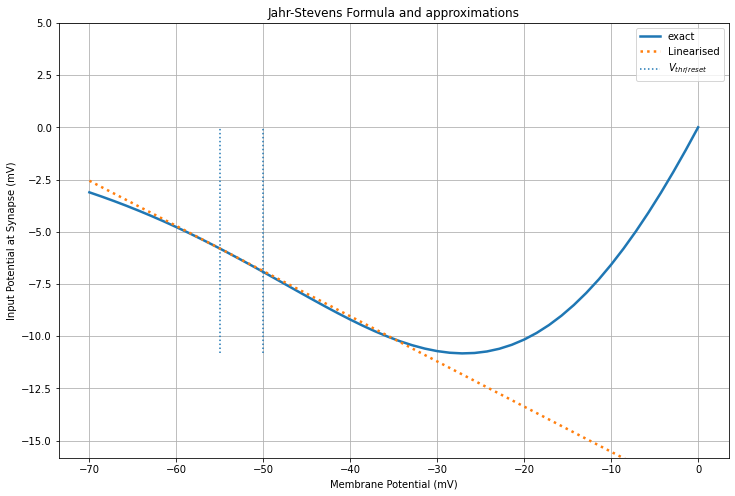

In [9]:
V = np.linspace(-70*pq.mV, 0*pq.mV, 50)
V_ = -55. * pq.mV

g_V = (V - V_E) / J(V)
g_V_linearised = (V_ - V_E) / J(V_) + (V - V_)*J_2(V_)

min_g = np.min(g_V)
max_g = np.max(g_V)

plt.figure(figsize=(12, 8))
plt.plot(V / pq.mV, g_V / pq.mV, label='exact', linewidth=2.5)
plt.plot(V / pq.mV, g_V_linearised / b2.mV, label='Linearised', linewidth=2.5, ls=':')
plt.vlines(
    [V_thr  / pq.mV,  V_reset / b2.mV],
    min_g / b2.mV, max_g / b2.mV,
    linestyle=':', label=r'$V_{thr/reset}$')
plt.xlabel('Membrane Potential (mV)')
plt.ylabel('Input Potential at Synapse (mV)')
plt.title("Jahr-Stevens Formula and approximations")
plt.ylim([min_g/b2.mV - 5, max_g/b2.mV + 5])
plt.legend()
plt.grid()

# plt.savefig('jahrstevens.png')
plt.show()

## Main differences start here:

In [10]:
W = np.ones((p+2, p+2))  # from column to row
for i in range(0, p+1):
    weights = np.full(p+2, w_minus)
    if i > 0:
        weights[i] = w_plus
    else:
        weights[i] = 1.0
    weights[-1] = 1.0
    weights[0] = 1.0
    W[:,i] = weights

(W * 100).astype(int).astype(float) / 100

array([[1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
       [0.87, 2.1 , 0.87, 0.87, 0.87, 0.87, 1.  ],
       [0.87, 0.87, 2.1 , 0.87, 0.87, 0.87, 1.  ],
       [0.87, 0.87, 0.87, 2.1 , 0.87, 0.87, 1.  ],
       [0.87, 0.87, 0.87, 0.87, 2.1 , 0.87, 1.  ],
       [0.87, 0.87, 0.87, 0.87, 0.87, 2.1 , 1.  ],
       [1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ]])

In [11]:
# g_AMPA_ext, g_AMPA_ext_E
# g_AMPA, g_AMPA_rec_E, g_AMPA_rec_I
# tau_rp, tau_rp_E
# V_reset, V_thr
# tau_m, tau_m_E, 0.5 * pq.nF / g_m_E
# tau_m, tau_m_I, 0.2 * pq.nF / g_m_I
# nu

In [12]:
pyramidal_mask = np.array([True] * (p+1) + [False])

C_k = np.array([N_non] + [N_sub] * p + [N_I])
# this method loses unit dimensions
g_m = np.array([g_m_E] * (p+1) + [g_m_I]) * b2.siemens
C_m = np.array([C_m_E] * (p+1) + [C_m_I]) * b2.siemens
tau_m = np.array([tau_m_E] * (p+1) + [tau_m_I]) * b2.second
tau_rp = np.array([tau_rp_E] * (p+1) + [tau_rp_I]) * b2.second

nu = np.array([rate_pyramidal] * (p+1) + [rate_interneuron]) * b2.Hz


# AMPA
g_AMPA = np.array([g_AMPA_rec_E]* (p+1) + [g_AMPA_rec_I]) * b2.siemens
s_AMPA = tau_AMPA * nu
s_AMPA[~pyramidal_mask] = 0.  # inhibitory neurons won't feed AMPA-mediated synapses
ip_AMPA = (V_drive - V_E) * C_k * s_AMPA
# ic_AMPA = W @ (g_AMPA * ip_AMPA)
ic_AMPA = g_AMPA * (W @ ip_AMPA)

# AMPA_ext
g_AMPA_ext = np.array([g_AMPA_ext_E]* (p+1) + [g_AMPA_ext_I]) * b2.siemens
s_AMPA_ext = np.full_like(
    s_AMPA,
    tau_AMPA * rate_ext
)
# ip_AMPA_ext = np.full_like(
#     ip_AMPA,
#     (V_drive - V_E) * C_ext * s_AMPA_ext
# )  # array to allow for differing inputs
ip_AMPA_ext = (V_drive - V_E) * C_ext * s_AMPA_ext
ic_AMPA_ext = g_AMPA_ext * ip_AMPA_ext

# GABA
g_GABA = np.array([g_GABA_E]* (p+1) + [g_GABA_I]) * b2.siemens
s_GABA = tau_GABA * nu
s_GABA[pyramidal_mask] = 0.
ip_GABA = (V_drive - V_I) * C_k * s_GABA
# ic_GABA = W @ (g_GABA * ip_GABA)
ic_GABA = g_GABA * (W @  ip_GABA)

# NMDA - requires self-consistent calculation
g_NMDA = np.array([g_NMDA_E]* (p+1) + [g_NMDA_I]) * b2.siemens
g_NMDA_eff = lambda V: g_NMDA * J_2(V)
V_E_eff = lambda V: V - (1 / J_2(V)) * (V - V_E) / J(V)
s_NMDA = psi(nu)
s_NMDA[~pyramidal_mask] = 0.
# g_NMDA_eff = lambda V: np.zeros(V.shape) * b2.siemens
V_avg_initial = -56. * b2.mV
V_avg = V_avg_initial

In [13]:
g_NMDA_eff_V = g_NMDA_eff(V_avg)
V_E_eff_V = V_E_eff(V_avg)
ip_NMDA = (V_drive - V_E_eff_V) * C_k * s_NMDA
# ic_NMDA = W @ (g_NMDA_eff_V * ip_NMDA)
ic_NMDA = g_NMDA_eff_V * (W @ ip_NMDA)
I_syn = ic_AMPA + ic_AMPA_ext + ic_NMDA + ic_GABA
V_SS = V_L - I_syn / g_m  # notice the - in current!!!
V_avg = V_SS - (V_thr-V_reset)*nu*tau_m - (V_SS-V_reset)*nu*tau_rp

In [14]:
V_SS, V_avg

(array([-57.91166112, -57.91166112, -57.91166112, -57.91166112,
        -57.91166112, -57.91166112, -58.06138367]) * mvolt,
 array([-58.19419115, -58.19419115, -58.19419115, -58.19419115,
        -58.19419115, -58.19419115, -58.29607675]) * mvolt)

In [15]:
for k in range(10):
    g_NMDA_eff_V = g_NMDA_eff(V_avg)
    V_E_eff_V = V_E_eff(V_avg)
    ip_NMDA = (V_drive - V_E_eff_V) * C_k * s_NMDA
    ic_NMDA = g_NMDA_eff_V * (W @ ip_NMDA)
    I_syn = ic_AMPA + ic_AMPA_ext + ic_NMDA + ic_GABA
    V_SS = V_L - I_syn / g_m  # notice the minus, because current flows out?
    V_avg = V_SS - (V_thr-V_reset)*nu*tau_m - (V_SS-V_reset)*nu*tau_rp
# ---

V_SS

array([-58.09843004, -58.09843004, -58.09843004, -58.09843004,
       -58.09843004, -58.09843004, -58.28917512]) * mvolt

In [16]:
# sigma taken from B&W2001
sigma = np.sqrt(g_AMPA_ext**2 * (V_drive - V_E)**2 * C_ext * rate_ext * tau_AMPA**2 / (g_m**2 * tau_m))

lambda_ = 0.8

sigma[:-1] = lambda_ * (2.0 * b2.mV) + (1-lambda_) * sigma[:-1]  # 5.* b2.mV
# sigma = 2.0 * b2.mV

sigma

array([1.87380259, 1.87380259, 1.87380259, 1.87380259, 1.87380259,
       1.87380259, 1.88488236]) * mvolt

In [17]:
def _rate_upperbound_vectorised(
    V_SS, sigma,
    tau_m=tau_m, tau_rp=tau_rp, tau_AMPA=tau_AMPA,
    V_thr=V_thr, V_L=V_L
):
    summand = (V_thr - V_SS)/sigma
    summand *= 1 + 0.5 * tau_AMPA/tau_m
    summand += 1.03 * np.sqrt(tau_AMPA/tau_m) - 0.5 * tau_AMPA/tau_m
    return summand

def _rate_lowerbound_vectorised(
    V_SS, sigma,
    tau_m=tau_m, tau_rp=tau_rp, tau_AMPA=tau_AMPA,
    V_thr=V_thr, V_L=V_L
):
    return (V_reset - V_SS) / sigma

def _siegert_integrand(x):
    return np.exp(x**2)*(1+special.erf(x))


root_pi = np.sqrt(np.pi)
def rate(
    V_SS, sigma,
    tau_m=tau_m, tau_rp=tau_rp, tau_AMPA=tau_AMPA,
    V_thr=V_thr, V_L=V_L
):
    integration_results = np.empty(V_SS.shape)
    UB = _rate_upperbound_vectorised(
        V_SS, sigma,
        tau_m=tau_m, tau_rp=tau_rp, tau_AMPA=tau_AMPA,
        V_thr=V_thr, V_L=V_L
    )
    LB = _rate_lowerbound_vectorised(
        V_SS, sigma,
        tau_m=tau_m, tau_rp=tau_rp, tau_AMPA=tau_AMPA,
        V_thr=V_thr, V_L=V_L
    )
    # There would be a dynamic programming solution
    # to computing multiple integrals by splitting 
    # this up into subintervals, integrating over 
    # them and adding them back together
    for i, (lb, ub) in enumerate(zip(LB, UB)):
        integral, error = integrate.quad(
            _siegert_integrand, lb, ub
        )
        integration_results[i] = integral
    return (tau_rp + tau_m * root_pi * integration_results)**-1

nu, \
rate(V_SS, sigma)

(array([3., 3., 3., 3., 3., 3., 5.]) * hertz,
 array([11.46704083, 11.46704083, 11.46704083, 11.46704083, 11.46704083,
        11.46704083,  0.529672  ]) * nhertz)

### The Main Loop

In [18]:
# from scipy import optimize

# def selfconsistentstates(states, s_NMDA, ic_AMPA, ic_AMPA_ext, ic_GABA):
#     V_avg = states[:p+2] * b2.mV
#     V_SS = states[p+2:2*(p+2)] * b2.mV
#     nu = states[2*(p+2):] * b2.Hz
#     g_NMDA_eff_V = g_NMDA_eff(V_avg)
#     V_E_eff_V = V_E_eff(V_avg)
#     ip_NMDA = (V_drive - V_E_eff_V) * C_k * s_NMDA
#     ic_NMDA = g_NMDA_eff_V * (W @ ip_NMDA)
#     I_syn = ic_AMPA + ic_AMPA_ext + ic_NMDA + ic_GABA
#     V_SS = V_L - I_syn / g_m
#     V_avg = V_SS - (V_thr-V_reset)*nu*tau_m - (V_SS-V_reset)*nu*tau_rp
#     nu = rate(V_SS, sigma)
#     return np.concatenate([V_avg / b2.mV, V_SS / b2.mV, nu / b2.Hz])


def ds_NMDA_dt(s_NMDA, nu):
    psi_nu = psi(nu)
    psi_nu[~pyramidal_mask] = 0.0
    tau_NMDA_eff = tau_NMDA * (1 - psi_nu)
    dsdt = -(s_NMDA - psi_nu) / tau_NMDA_eff
    return dsdt

def dic_noise_dt(
    ic_noise, sigma_noise=0.007*b2.nA
):
    eta = np.random.randn(*ic_noise.shape)
    dicdt = (-ic_noise + eta * np.sqrt(tau_AMPA/defaultdt) * sigma_noise) / tau_AMPA
    return dicdt

# Following W&W2006
# 1. Treat all firing rates and synaptic variables as dynamic
# 2. use tau_r=2ms for the firing rate dynamics
# 3. phi(I_syn) = rates(V_SS_new = V_L - I_syn / g_m)
def phi(I_syn, sigma=sigma):
    V_SS = V_L - I_syn/g_m
    return rate(V_SS, sigma=sigma)


tau_r = 2 * b2.ms
def dnu_dt(nu, I_syn, sigma=sigma):
    phi_Isyn = phi(I_syn, sigma=sigma)
    deriv = (-nu + phi_Isyn)/tau_r
    return deriv

def ds_AMPA_dt(s_AMPA, nu):
    deriv = -s_AMPA/tau_AMPA + nu
    deriv[~pyramidal_mask] = 0.0 * b2.Hz
    return deriv

def ds_GABA_dt(s_GABA, nu):
    deriv = -s_GABA/tau_GABA + nu
    deriv[pyramidal_mask] = 0.0 * b2.Hz
    return deriv

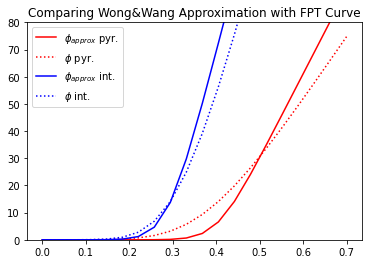

In [19]:
# comparing with Wong&Wang approximate firing rate
c_gain = np.array([310.]*(p+1) + [615.]) / (b2.second * b2.amp * 1e-9)
I_thr =  np.array([125.]*(p+1) + [177.]) * b2.Hz
g_noise =  np.array([0.16]*(p+1) + [0.087]) * b2.second
def phi_approx(I_syn):
    numerator = c_gain * I_syn - I_thr
    denominator = 1 - np.exp(-g_noise*(numerator))
    return numerator / denominator

inp_ = np.linspace(0.0, 0.7, 20) * b2.nA
r = np.array([phi_approx(x) for x in inp_]) * b2.Hz
# notice the - in front of the current
r_2 = np.array([phi(-x, sigma=6.5 *b2.mV) for x in inp_]) * b2.Hz
plt.plot(inp_ / b2.nA, r[:, 0] / b2.Hz, 'r', label='$\phi_{approx}$ pyr.')
plt.plot(inp_ / b2.nA, r_2[:, 0] / b2.Hz, 'r:', label='$\phi$ pyr.')
plt.plot(inp_ / b2.nA, r[:, -1] / b2.Hz, 'b', label='$\phi_{approx}$ int.')
plt.plot(inp_ / b2.nA, r_2[:, -1] / b2.Hz, 'b:', label='$\phi$ int.')
plt.ylim([0, 80])
plt.legend()
plt.title('Comparing Wong&Wang Approximation with FPT Curve')
plt.show()

In [20]:
# from tqdm.notebook import tqdm
from tqdm import tqdm

total_time = 400 * b2.ms
times = np.arange(0*b2.ms, total_time, defaultdt)

nu_tracked = np.zeros((p+2, times.shape[0])) * b2.Hz
s_NMDA_tracked = np.zeros((p+2, times.shape[0]))
s_AMPA_tracked = np.zeros((p+2, times.shape[0]))
s_GABA_tracked = np.zeros((p+2, times.shape[0]))
I_syn_tracked = np.zeros((p+2, times.shape[0])) * b2.amp

ic_noise = np.zeros_like(s_AMPA) * b2.nA
# V_avg = -52.5 * b2.mV
for itr, t in tqdm(enumerate(times)):
    ip_AMPA = (V_drive - V_E) * C_k * s_AMPA
    ic_AMPA = g_AMPA * (W @ ip_AMPA)
    
    g_NMDA_eff_V = g_NMDA_eff(V_avg)
    V_E_eff_V = V_E_eff(V_avg)
    ip_NMDA = (V_drive - V_E_eff_V) * C_k * s_NMDA
    ic_NMDA = g_NMDA_eff_V * (W @ ip_NMDA)
    
    ip_GABA = (V_drive - V_I) * C_k * s_GABA
    ic_GABA = g_GABA * (W @  ip_GABA)
    
    
    ## LATEST CHANGE: added noise adapting to changing input by adapting s_AMPA_ext
    s_AMPA_ext = np.full_like(
        s_AMPA,
        tau_AMPA * rate_ext
    )
#     if t > 200. * b2.ms and t < 225. * b2.ms:
#         # increase input by roughly 1.5 times
#         s_AMPA_ext[2] = s_AMPA_ext[2] * 1.5  #(25. * b2.Hz + rate_ext) / rate_ext
    ip_AMPA_ext = (V_drive - V_E) * C_ext * s_AMPA_ext
    ic_AMPA_ext = g_AMPA_ext * ip_AMPA_ext
#     sigma = np.sqrt(g_AMPA_ext**2 * (V_drive - V_E)**2 * C_ext * s_AMPA_ext * tau_AMPA / (g_m**2 * tau_m))
    ## END OF LAST CHANGE
    
    I_syn = ic_AMPA + ic_AMPA_ext + ic_NMDA + ic_GABA + ic_noise
    
    dnu_dt_now = dnu_dt(nu, I_syn, sigma=sigma)
    dic_noise_dt_now = dic_noise_dt(ic_noise)
    ds_NMDA_dt_now = ds_NMDA_dt(s_NMDA, nu)
    ds_AMPA_dt_now = ds_AMPA_dt(s_AMPA, nu)
    ds_GABA_dt_now = ds_GABA_dt(s_GABA, nu)
    
    nu += dnu_dt_now * defaultdt
    ic_noise += dic_noise_dt_now * defaultdt
    s_NMDA += ds_NMDA_dt_now * defaultdt
    s_AMPA += ds_AMPA_dt_now * defaultdt
    s_GABA += ds_GABA_dt_now * defaultdt
    
    nu_tracked[:, itr] = nu
    s_NMDA_tracked[:, itr] = s_NMDA
    s_AMPA_tracked[:, itr] = s_AMPA
    s_GABA_tracked[:, itr] = s_GABA
    I_syn_tracked[:, itr] = I_syn
    
    # Not mentioned in W&W2006:
    V_SS = V_L - I_syn / g_m
    V_avg = V_SS - (V_thr-V_reset)*nu*tau_m - (V_SS-V_reset)*nu*tau_rp

5445it [00:17, 281.54it/s]WARNING    <ipython-input-17-cd2e07eca078>:44: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, error = integrate.quad(
 [py.warnings]
WARNING    <ipython-input-17-cd2e07eca078>:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, error = integrate.quad(
 [py.warnings]
8000it [00:48, 165.06it/s]


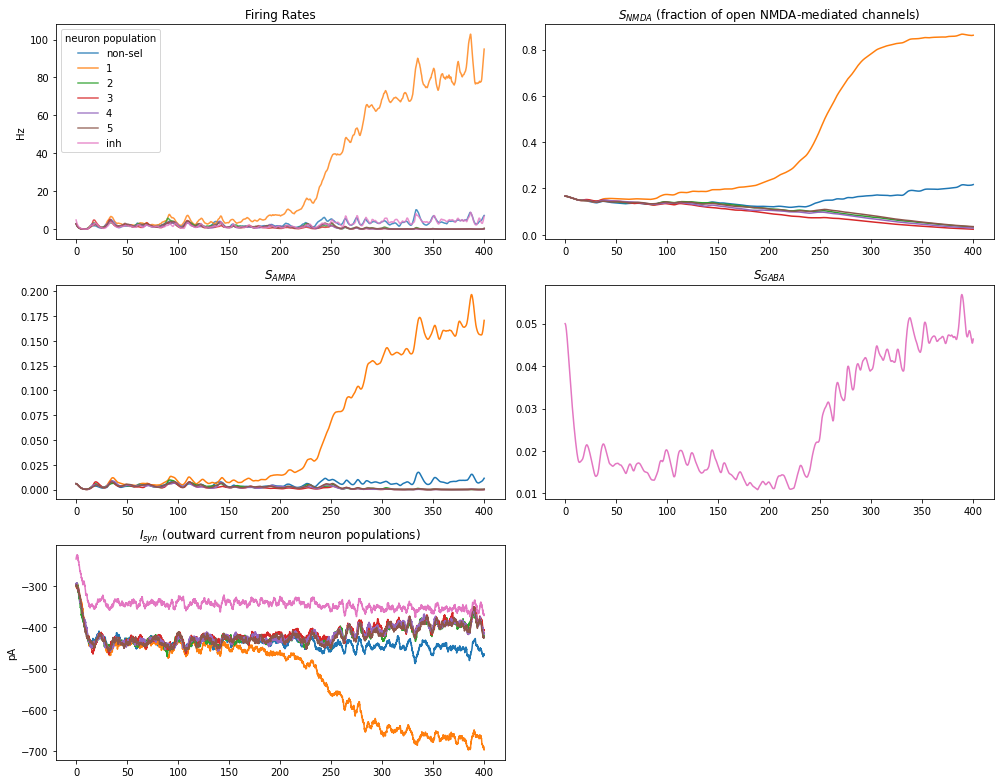

In [21]:
fig, axes = plt.subplots(3, 2, figsize=(14,11))

# clear_output(wait=True)
rates_lines = axes[0][0].plot(
    times/b2.ms, nu_tracked.T/b2.Hz,
    alpha=0.8
)
# axes[0][0].legend(
#     [rates_lines[0], rates_lines[-1]],
#     ['non-sel', 'inh']
# )
axes[0][0].legend(
    rates_lines,
    ['non-sel'] + list(range(1, p+1)) +  ['inh'],
    title='neuron population',
)
# axes[0][0].set_ylim([0., 40.])
axes[0][0].set_ylabel('Hz')
axes[0][0].set_title('Firing Rates')
axes[0][1].plot(times/b2.ms, s_NMDA_tracked[pyramidal_mask, :].T)
axes[0][1].set_title('$S_{NMDA}$ (fraction of open NMDA-mediated channels)')
axes[1][0].plot(times/b2.ms, s_AMPA_tracked[pyramidal_mask, :].T)
axes[1][0].set_title('$S_{AMPA}$')
axes[1][1].plot(times/b2.ms, s_GABA_tracked[~pyramidal_mask, :].T, color=rates_lines[-1].get_color())
axes[1][1].set_title('$S_{GABA}$')
axes[2][0].plot(times/b2.ms, I_syn_tracked.T / b2.pA)
axes[2][0].set_ylabel('pA')
axes[2][0].set_title('$I_{syn}$ (outward current from neuron populations)')
axes[2][1].axis('off')

fig.savefig("Success.png")
plt.tight_layout()
plt.show(fig)

Somehow using a vector for sigma causes the network to go quiet...

**Wong and Wang above**

TODO:  

* fit firing-rate function which converges
* figure out what noise should be used
* try to match up firing rates with true model
* increase external input to a population and see what happens

---

**Renart, Brunel and Wang below**

In [22]:
total_time = 500 * b2.ms
times = np.arange(0*b2.ms, total_time, defaultdt)

ic_noise = np.zeros_like(s_AMPA) * b2.nA

rates_tracked = np.zeros((nu.shape[0], times.shape[0]))
s_NMDA_tracked = np.zeros((nu.shape[0], times.shape[0]))
V_SS_tracked = np.zeros((nu.shape[0], times.shape[0]))
for itr, t in enumerate(times):
    rates_tracked[:, itr] = nu
    s_NMDA_tracked[:, itr] = s_NMDA
    V_SS_tracked[:, itr] = V_SS
    
    dsdt = ds_NMDA_dt(s_NMDA, nu)
    s_NMDA += dsdt * defaultdt  # Euler method
    
    dic_dt = dic_noise_dt(ic_noise)
    ic_noise += dic_dt * defaultdt
    
    for k in range(101):
        s_AMPA = tau_AMPA * nu
        s_AMPA[~pyramidal_mask] = 0.
        ip_AMPA = (V_drive - V_E) * C_k * s_AMPA
        ic_AMPA = g_AMPA * (W @ ip_AMPA)

        # s_AMPA_ext = tau_AMPA * rate_ext
        # ip_AMPA_ext = np.full_like(
        #     ip_AMPA,
        #     (V_drive - V_E) * C_ext * s_AMPA_ext
        # )
        # ic_AMPA_ext = g_AMPA_ext * ip_AMPA_ext

        s_GABA = tau_GABA * nu
        s_GABA[pyramidal_mask] = 0.
        ip_GABA = (V_drive - V_I) * C_k * s_GABA
        ic_GABA = g_GABA * (W @  ip_GABA)
    

    
        g_NMDA_eff_V = g_NMDA_eff(V_avg)
        V_E_eff_V = V_E_eff(V_avg)
        ip_NMDA = (V_drive - V_E_eff_V) * C_k * s_NMDA
        ic_NMDA = g_NMDA_eff_V * (W @ ip_NMDA)
        I_syn = ic_AMPA + ic_AMPA_ext + ic_NMDA + ic_GABA + ic_noise
        
        V_SS_new = V_L - I_syn / g_m  # notice the minus, because current flows out?
        nu_new = rate(V_SS, sigma)
        V_avg = V_SS - (V_thr-V_reset)*nu*tau_m - (V_SS-V_reset)*nu*tau_rp
        
        V_SS = V_SS_new
        nu = nu_new

WARNING    <ipython-input-17-cd2e07eca078>:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, error = integrate.quad(
 [py.warnings]
WARNING    /home/dean/anaconda3/envs/masters/lib/python3.8/site-packages/brian2/units/fundamentalunits.py:208: RuntimeWarning: overflow encountered in exp
  return func(np.array(x, copy=False), *args, **kwds)
 [py.warnings]
WARNING    <ipython-input-17-cd2e07eca078>:19: RuntimeWarning: invalid value encountered in double_scalars
  return np.exp(x**2)*(1+special.erf(x))
 [py.warnings]
WARNING    <ipython-input-17-cd2e07eca078>:44: Integration

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(rates_tracked[:, :30].T / b2.Hz);
plt.ylabel('Firing Rate (Hz)')
plt.grid()

plt.figure(figsize=(12, 6))
plt.plot(V_SS_tracked[:, :30].T / b2.mV);
plt.ylabel('$V_{SS}$ (mV)')
plt.grid()

plt.figure(figsize=(12, 6))
plt.plot(s_NMDA_tracked[:-1, :30].T);
plt.ylabel('$S_{NMDA}$')
plt.grid()

plt.show()

In [ ]:
# states = np.concatenate([V_avg / b2.mV, V_SS / b2.mV, nu / b2.Hz])
# states_new = optimize.fixed_point(
#     selfconsistentstates,
#     x0=states,
#     args=(s_NMDA, ic_AMPA, ic_AMPA_ext, ic_GABA),
#     xtol=1e-5
# )

In [ ]:
# states = np.concatenate([V_avg / b2.mV, V_SS / b2.mV, nu / b2.Hz])
# # print(states)
# for i in range(10):
#     states_new = selfconsistentstates(states, s_NMDA, ic_AMPA, ic_AMPA_ext, ic_GABA)
# #     print(states_new)
#     print(np.abs(states - states_new))
#     states = states_new

# optimize.fixed_point(selfconsistentstates, x0=states, args=(s_NMDA, ic_AMPA, ic_AMPA_ext, ic_GABA))

In [ ]:
for tau_m_loop, tau_rp_loop in zip([tau_m_E, tau_m_I], [tau_rp_E, tau_rp_I]):
    V_values = np.linspace(-80, -30, 200) * b2.mV
    rates = rate(
        V_SS=V_values,
#         sigma=2.73 * b2.mV,
        sigma=5. * b2.mV,
        tau_m=tau_m_loop, tau_rp=tau_rp_loop
    )

    plt.plot(V_values / b2.mV, rates / b2.Hz)
plt.xlim([None, -40.])
plt.ylim([0., 100.])

In [ ]:
# s_AMPA = tau_AMPA * nu  # + noise for all of these...
# s_AMPA[~pyramidal_mask] = 0.  # inhibitory neurons won't feed AMPA-mediated synapses
# s_NMDA = psi(nu)  # dynamic variable, initialised at steady-state
# s_NMDA[~pyramidal_mask] = 0.
# s_GABA = tau_GABA * nu
# s_GABA[pyramidal_mask] = 0.

# # ip = 'input potential'
# ip_AMPA = (V_drive - V_E) * C_k * s_AMPA
# ip_AMPA_ext = np.full_like(
#     ip_AMPA,
#     (V_drive - V_E) * C_ext * s_AMPA_ext
# )  # array to allow for differing inputs
# ip_NMDA = (V_drive - V_E) * C_k * s_NMDA
# ip_GABA = (V_drive - V_I) * C_k * s_GABA

# # V_avg needs to be computed self-consistently with input potential/V_SS
# g_NMDA_eff = lambda V: np.array([g_NMDA_E]* (p+1) + [g_NMDA_I]) * b2.siemens * J_2(V)
# V_avg_initial = -52.5 * b2.mV

# # run to convergence
# V_avg = V_avg_initial
# for k in range(90):
#     g_AMPA = np.array([g_AMPA_rec_E]* (p+1) + [g_AMPA_rec_I]) * b2.siemens
#     g_AMPA_ext = np.array([g_AMPA_ext_E]* (p+1) + [g_AMPA_ext_I]) * b2.siemens
#     g_NMDA_eff_V = g_NMDA_eff(V_avg)
#     g_GABA = np.array([g_GABA_E]* (p+1) + [g_GABA_I]) * b2.siemens

#     ic_AMPA = W @ (g_AMPA * ip_AMPA)
#     ic_AMPA_ext = g_AMPA_ext * ip_AMPA_ext
#     ic_NMDA = W @ (g_NMDA_eff_V * ip_NMDA)
#     ic_GABA = W @ (g_GABA * ip_GABA)
#     # + add noise here
#     I_syn = ic_AMPA + ic_AMPA_ext + ic_NMDA + ic_GABA

#     V_SS = V_L + I_syn / g_m
#     # V_avg seems a bit high, being as it is above the firing threshold
#     V_avg = V_SS - (V_thr-V_reset)*nu*tau_m # - (V_SS-V_reset)*nu*tau_rp

In [ ]:
## Show that the same fixed point is typically found...

# for V_avg_initial in [-90*b2.mV, -50*b2.mV, 0*b2.mV, 20 * b2.mV]:
#     V_avg = V_avg_initial

#     V_avg_1 = []
#     V_SS_1 = []
#     for k in range(90):
#         g_AMPA = np.array([g_AMPA_rec_E]* (p+1) + [g_AMPA_rec_I]) * b2.siemens
#         g_AMPA_ext = np.array([g_AMPA_ext_E]* (p+1) + [g_AMPA_ext_I]) * b2.siemens
#         g_NMDA_eff_V = g_NMDA_eff(V_avg)
#         g_GABA = np.array([g_GABA_E]* (p+1) + [g_GABA_I]) * b2.siemens

#         ic_AMPA = W @ (g_AMPA * ip_AMPA)
#         ic_AMPA_ext = g_AMPA_ext * ip_AMPA_ext
#         ic_NMDA = W @ (g_NMDA_eff_V * ip_NMDA)
#         ic_GABA = W @ (g_GABA * ip_GABA)
#         # + add noise here
#         I_syn = ic_AMPA + ic_AMPA_ext + ic_NMDA + ic_GABA

#         V_SS = V_L + I_syn / g_m
#         # V_avg seems a bit high, being as it is above the firing threshold
#         V_avg = V_SS - (V_thr-V_reset)*nu*tau_m #- (V_SS-V_reset)*nu*tau_rp
#         V_avg_1.append(V_avg[0])
#         V_SS_1.append(V_SS[0])
# #         if k > 85:    print(V_avg)
#     plt.plot(V_avg_1 / b2.mV)
#     plt.plot(V_SS_1 / b2.mV)

$$
\begin{split}
\tau_V \frac{dV(t)}{dt} &= -(V(t) - V_{steadystate}) + \frac{\delta I(t)}{g}\\
\tau_C \frac{d\delta I(t)}{dt} &= -\delta I(t) + \sigma_C \eta(t)\\
\eta(t) &\sim \mathcal{N}\left(0, \frac{1}{\sqrt{dt}}\right)
\end{split}
$$